# WIP

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import data

In [121]:
import os
import datetime as dt

main_path = os.getcwd()
start_date = pd.to_datetime('2018-03-01')
end_date = start_date + dt.timedelta(5*365)
period_pred = end_date + dt.timedelta(30)

df_P = pd.read_pickle(main_path+'\\data\\exchange_rates.pkl')
df_P = df_P.fillna(method='ffill').drop(df_P.index[0])
df_P = df_P.loc[(df_P.index > start_date) & (df_P.index < end_date)]

df_r = pd.read_pickle(main_path+'\\data\\log_return.pkl')
df_r = df_r.fillna(method='ffill').dropna()
df_r = df_r.loc[(df_r.index > start_date) & (df_r.index < end_date)]


# Kalman filter fucntion

In [119]:
import numpy as np
from pykalman import KalmanFilter

def fitKCA(t,z,q,fwd=0):
    '''
    Args:
        t: iterable with time indices
        z: iterable with measurements
        q: scalar that multiplies the seed states covariance
        fwd: number of steps to forecast (default to 0)
    Returns:
        x[0]: smoothed state means of position velocity and acceleration
        x[1]: smoothed state covar of position velocity and acceleration
    '''
    #monthly timestep
    h = (t[-1] - t[0])/t.shape[0]
    
    A = np.array([[1, h, 0.5*h**2],
                 [0, 1, h],
                 [0, 0, 1]])
    Q = q*np.eye(A.shape[0])

    #set up Kalman filter
    kf = KalmanFilter(transition_matrices=A, transition_covariance=Q)

    #EM for parameter esimtates
    kf = kf.em(z)

    #smooth
    x_mean, x_cov = kf.smooth(z)

    #forecast
    for fwd_ in range(fwd):
        x_mean_, x_cov_ = kf.filter_update(filtered_state_mean=x_mean[-1],
                                         filtered_state_covariance=x_cov[-1])
        x_mean = np.append(x_mean, x_mean_.reshape(1,-1), axis=0)
        x_cov_ = np.expand_dims(x_cov_, axis=0)
        x_cov = np.append(x_cov, x_cov_, axis=0)

    #std series
    x_std = (x_cov[:,0,0]**0.5).reshape(-1,1)
    for i in range(1, x_cov.shape[1]):
        x_std_ = x_cov[:,i,i]**0.5
        x_std = np.append(x_std, x_std_.reshape(-1,1), axis=1)
        
    return x_mean, x_std, x_cov

## Demo with only 1 asset

In [8]:
# raw = pd.read_csv('C:/Users/janeg/cornell_projects/Opt_proj/DEXJPUS.csv')
# df = raw[raw['DATETIME'] >= '2000-05-01']
# df = df.set_index(pd.to_datetime(df['DATETIME'])).drop(columns=['DATETIME'])

t_date = df_P.index
t_day = np.array(range(len(t_date)))
t = np.array(range(len(t_date)))/20 #20 trading days
z = np.array(df_P.iloc[:,0])
z_r = np.array(df_r.iloc[:,0])
title = df_P.columns[0]


In [145]:
########## test with P_sample, r_sample ##########
t_date = r_sample.index
t_day = np.array(range(len(t_date)))
t = np.array(range(len(t_date)))/20 #20 trading days
z = np.array(P_sample.iloc[:,0])
z_r = np.array(r_sample.iloc[:,0])

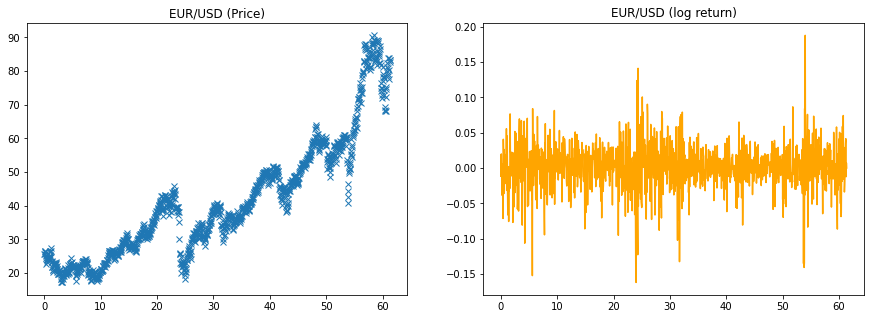

In [146]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
ax1.plot(t,z,marker='x',linestyle='')
ax1.set_title(title+' (Price)')
ax2.plot(t,z_r,linestyle='-', color='orange')
ax2.set_title(title+' (log return)')
plt.show()

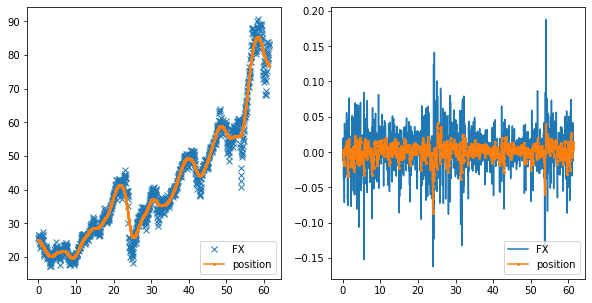

In [148]:
#smoothing result
x_point, x_bands, x_cov = fitKCA(t, z, q=1e-3, fwd=0)
xr_point, xr_bands, xr_cov = fitKCA(t, z_r, q=1e-3, fwd=0)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.plot(t, z, marker='x', linestyle='',label='FX')
ax1.plot(t, x_point[:,0], marker='o', linestyle='-', markersize=2, label='position')
ax1.legend(loc="lower right")

ax2.plot(t, z_r, linestyle='-',label='FX')
ax2.plot(t, xr_point[:,0], marker='o', linestyle='-', markersize=2, label='position')
ax2.legend(loc="lower right")
plt.show()

In [56]:
mean_accel_P = x_point[:,2].mean()
mean_accel_r = xr_point[:,2].mean()
print(f"mean accelartion: P = {mean_accel_P:.6f}, r = {mean_accel_r:.6f}")

std_accel_P = x_point[:,2].std()
std_accel_r = xr_point[:,2].std()
print(f"std accelartion: P = {std_accel_P:.6f}, r = {std_accel_r:.6f}")


mean accelartion: P = -0.000554, r = 0.000057
std accelartion: P = 0.005165, r = 0.000683


## Apply Kalman Filter to all assets

In [7]:
r_km = np.zeros((df_r.shape))
for i in range(df_r.shape[1]):
    z_r = np.array(df_r.iloc[:,i])
    xr_point, xr_bands = fitKCA(t, z_r, q=1e-5, fwd=0)[:2]
    r_km[:,i] = xr_point[:,0]
df_export = pd.DataFrame(r_km)

In [9]:
# export r_km
df_export.to_pickle('r_km.pkl')

# Markowitz with monthly rebalancing

In [154]:
def adaptedStats(log_return, trade_date, horizon, rate_of_decay=0):
    """Projects filtered daily data to monthly holding data
    
    Args:
        log_return: filtered log_return from Kalman/ARIMA/GARCH/MCM
        trade_date: the day when rebalancing happens
        horizon: days of holding period (for monthly rebalacing, horizon=20)
        rate_of_decay: assigning weight to each return in history (the older, 
        the smaller weight). Default setting is 0

    Retuns:
        mu: arithmetic mean vector of historical returns 
        V: covariance matrix of arithmetic means
    """
    h = horizon
    c_r = log_return
    t_d = trade_date
    n_s = trade_date #use all the historical data available so far
    r_d = rate_of_decay

    s_d = np.array(range(t_d))
    s_c_r = c_r[s_d,:]  #sampled log return matrix

    #construct weights
    w = (1 - r_d)**np.array(range(n_s))
    w = w[::-1]/np.sum(w)

    #mean vector of compounded returns
    mean_c_r = s_c_r.T.dot(w)
    # print('mena vector', mean_c_r)

    #covariance matrix of compounded returns
    cov_c_r = s_c_r.T.dot(np.diag(w)).dot(s_c_r) - mean_c_r.dot(mean_c_r.T)

    #adapted mean
    adapted_mean_c_r = h * mean_c_r

    #adapted covariance
    adapted_cov_c_r = h * cov_c_r

    #arithmetic mean for markowitz
    mu = np.exp(adapted_mean_c_r + 0.5*np.diag(adapted_cov_c_r)) - 1

    #covariance matrix of arithmetic mean
    V = mu.dot(mu.T)*(np.exp(adapted_cov_c_r) - 1)

    return mu, V


## Markowitz CVX

In [80]:
import cvxpy as cp

def benchmark(benchmark_xx0, benchmark_xx, trans_cost):
    """Calculates equally weighted benchmark portfolio
    
    Args:
        benchmark_xx0: wealth now in the bank
        benchmark_xx: wealth now invested in risky assets
        trans_cost: transactopm costs per unit of wealth invested/divested in assets

    Returns:
        benchmark_x0: new wealth currently in bank (scalar)
        benchmark_x: new wealth currently in risky assests (vector of size n)
    """
    n = len(benchmark_xx)
    w = cp.Variable()
    req = benchmark_xx0 + cp.sum(benchmark_xx) - trans_cost * cp.sum(cp.abs(w - benchmark_xx))
    prob = cp.Problem(cp.Maximize(w), [(n+1) * w <= req])
    prob.solve()

    benchmark_x0 = w.value
    benchmark_x = w.value * np.ones((n,1))
    return benchmark_x0, benchmark_x


def markowitz(mu0, mu, V, sigma, xx, trans_cost):
    """Optimizes portfolio
    
    Args:
        mu0: risk-free rate
        mu: rate of return of risky assets
        V: covariance matrix of the risky assets
        sigma: user-defined sigma
        xx = risky assets currently owned
        trans_cost: transaction cost per unit of weatlh invested/divested in assets

    Returns:

        
    """
    n = len(mu)
    mu = np.array(mu.reshape(-1,1))
    # U = np.linalg.cholesky(V)
    e = np.ones((n, 1))

    x0, total_trans_cost = cp.Variable(), cp.Variable()
    x, y = cp.Variable(n), cp.Variable(n)

    prob = cp.Problem(cp.Maximize((1 + mu0) * x0 + (e + mu).T @ x),
                      [x0 + cp.sum(x) + total_trans_cost == 1,
                       x == xx + y, #y: asset amounts to be rebalanced
                       total_trans_cost >= trans_cost*cp.sum(cp.abs(y)),
                    #    cp.norm(U.dot(x)) <= sigma,
                       x.T @ V @ x <= sigma**2,
                       x0 >= 0])
    
    prob.solve()

    return x0, x

In [127]:
r_km = np.array(pd.read_pickle('r_km.pkl'))

horizon = 20 # rebalance monthly (every 20 trading days)
start = 250 #initial rebalancing strats at the 250th trading day
number_rebalances = int((t_day[-1]-start)/horizon) + 1
rebalance_dates = start + horizon * np.array(range(number_rebalances))
rate_of_decay = 0 #no decay    

In [129]:
#set up initial states of an equally-weighted portfolio
risk_free_rate = pd.read_pickle(main_path+'\\data\\risk_free_rate.pkl')
rf = pd.merge(risk_free_rate, df_r, left_index=True, right_index=True, how='right')['Close']
rf = rf.fillna(method='ffill') 
n = r_km.shape[1]
e = np.ones(n)

allowable_risk = 1.5
trans_cost = 0.005
wealth = 10000
wealth0, benchmark_wealth = wealth,  wealth

benchmark_xx0, xx0 = 1/(n+1), 1/(n+1) # %money in bank
benchmark_xx, xx = e/(n+1), e/(n+1)  # %money in each of risky asset

##########################################################
# for i in range(len(rebalance_dates)):
#     trade_date = rebalance_dates[i]
#     mu, V = adaptedStats(r_km, trade_date, horizon, rate_of_decay)
###########################################################

trade_date = rebalance_dates[0]
mu, V = adaptedStats(r_km, trade_date, horizon, rate_of_decay)    
mu0 = (1 + 0.01 * rf[trade_date - 1]) ** (horizon / 270) - 1

# rebalancing benchmark portfolio
benchmark_x0, benchmark_x = benchmark(benchmark_xx0, benchmark_xx, trans_cost)
benchmark_risk = np.sqrt(benchmark_x.T @ V @ benchmark_x)
sigma = allowable_risk * benchmark_risk

# rebalancing optimized portfolio
x0, x = markowitz(mu0, mu, V, sigma, xx, trans_cost)

mena vector [-3.00583908e-04 -2.66672842e-04 -2.54608006e-04 -1.27958777e-04
 -6.29710451e-04 -1.41116451e-04 -3.49403203e-04 -2.47944663e-04
 -1.37977046e-04 -1.15253137e-05 -5.32080608e-05  7.78791769e-06
  7.88304264e-07  6.43633049e-06  4.33006369e-06]
**** [-3.00583908e-04 -2.66672842e-04 -2.54608006e-04 -1.27958777e-04
 -6.29710451e-04 -1.41116451e-04 -3.49403203e-04 -2.47944663e-04
 -1.37977046e-04 -1.15253137e-05 -5.32080608e-05  7.78791769e-06
  7.88304264e-07  6.43633049e-06  4.33006369e-06]
[[ 1.23787733e-06 -1.89528777e-07  7.29252153e-07 -9.99461883e-08
  -6.38249731e-07 -3.99691489e-07  3.17554348e-07  4.17293962e-07
   7.15726658e-08 -8.23388389e-07 -6.62748089e-07 -8.81496916e-07
  -8.53787350e-07 -8.65984535e-07 -8.10130604e-07]
 [-1.89528777e-07  4.95732436e-07 -7.71688535e-08 -3.22584310e-07
  -6.03429152e-07 -7.11685241e-07 -1.07295510e-07 -5.50503984e-07
  -1.11270717e-07 -8.45841486e-07 -7.49193532e-07 -8.62351690e-07
  -8.41727638e-07 -8.74723808e-07 -8.96904389e

<ipython-input-129-95012061883c>:28: RuntimeWarning: invalid value encountered in sqrt
  benchmark_risk = np.sqrt(benchmark_x.T @ V @ benchmark_x)


DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
QuadForm(var5013, [[ 8.46614288e-09 -1.29621470e-09  4.98750672e-09 -6.83547043e-10
  -4.36506259e-09 -2.73354213e-09  2.17181111e-09  2.85395105e-09
   4.89497087e-10 -5.63123653e-09 -4.53260854e-09 -6.02864313e-09
  -5.83913633e-09 -5.92255337e-09 -5.54056593e-09]
 [-1.29621470e-09  3.39040903e-09 -5.27769539e-10 -2.20619780e-09
  -4.12692213e-09 -4.86729284e-09 -7.33810111e-10 -3.76496274e-09
  -7.60997116e-10 -5.78479423e-09 -5.12381420e-09 -5.89770819e-09
  -5.75665946e-09 -5.98232159e-09 -6.13401539e-09]
 [ 4.98750672e-09 -5.27769539e-10  1.16154671e-08 -8.81934737e-11
  -3.16032047e-09 -4.02081483e-09  1.46550838e-09 -3.29503600e-10
  -1.38056315e-09 -5.86972455e-09 -4.68475886e-09 -5.72371248e-09
  -6.12870879e-09 -6.05704836e-09 -6.74906227e-09]
 [-6.83547043e-10 -2.20619780e-09 -8.81934737e-11  7.34835644e-09
  -5.15879953e-09 -7.02794974e-09  2.80519670e-09 -3.54754982e-09
  -1.43408830e-09 -5.83385170e-09 -5.26747484e-09 -5.88958800e-09
  -6.08023316e-09 -6.07636962e-09 -5.97340971e-09]
 [-4.36506259e-09 -4.12692213e-09 -3.16032047e-09 -5.15879953e-09
   4.23698985e-09 -5.11262825e-09 -2.24191786e-09 -4.78204841e-09
  -5.94007501e-09 -5.74426540e-09 -5.53068200e-09 -5.94751857e-09
  -5.78120239e-09 -5.94618483e-09 -5.69965162e-09]
 [-2.73354213e-09 -4.86729284e-09 -4.02081483e-09 -7.02794974e-09
  -5.11262825e-09  5.62128462e-09 -6.33656947e-09 -3.31546152e-10
  -4.62100258e-09 -6.19307796e-09 -5.39810034e-09 -5.86385250e-09
  -5.94082217e-09 -5.75015551e-09 -5.21716651e-09]
 [ 2.17181111e-09 -7.33810111e-10  1.46550838e-09  2.80519670e-09
  -2.24191786e-09 -6.33656947e-09  1.03366999e-08 -9.50730916e-10
   2.06830265e-09 -5.32945771e-09 -5.27074072e-09 -6.32707572e-09
  -5.92856302e-09 -6.17040544e-09 -6.67699687e-09]
 [ 2.85395105e-09 -3.76496274e-09 -3.29503600e-10 -3.54754982e-09
  -4.78204841e-09 -3.31546152e-10 -9.50730916e-10  5.99969743e-09
  -2.52359066e-09 -5.56062535e-09 -4.89130716e-09 -6.14139813e-09
  -5.77917251e-09 -5.92387671e-09 -5.54158632e-09]
 [ 4.89497087e-10 -7.60997116e-10 -1.38056315e-09 -1.43408830e-09
  -5.94007501e-09 -4.62100258e-09  2.06830265e-09 -2.52359066e-09
   6.10625741e-09 -5.54018825e-09 -5.45400800e-09 -6.32219369e-09
  -5.57857268e-09 -6.11619998e-09 -6.51585980e-09]
 [-5.63123653e-09 -5.78479423e-09 -5.86972455e-09 -5.83385170e-09
  -5.74426540e-09 -6.19307796e-09 -5.32945771e-09 -5.56062535e-09
  -5.54018825e-09 -5.49527350e-09 -5.87711123e-09 -5.95272582e-09
  -5.90946761e-09 -5.92697653e-09 -6.06453639e-09]
 [-4.53260854e-09 -5.12381420e-09 -4.68475886e-09 -5.26747484e-09
  -5.53068200e-09 -5.39810034e-09 -5.27074072e-09 -4.89130716e-09
  -5.45400800e-09 -5.87711123e-09 -4.94716074e-09 -5.91031925e-09
  -5.90024216e-09 -5.98679945e-09 -5.92871234e-09]
 [-6.02864313e-09 -5.89770819e-09 -5.72371248e-09 -5.88958800e-09
  -5.94751857e-09 -5.86385250e-09 -6.32707572e-09 -6.14139813e-09
  -6.32219369e-09 -5.95272582e-09 -5.91031925e-09 -4.60448196e-09
  -5.63641094e-09 -5.55923878e-09 -5.56455159e-09]
 [-5.83913633e-09 -5.75665946e-09 -6.12870879e-09 -6.08023316e-09
  -5.78120239e-09 -5.94082217e-09 -5.92856302e-09 -5.77917251e-09
  -5.57857268e-09 -5.90946761e-09 -5.90024216e-09 -5.63641094e-09
  -4.63971960e-09 -5.90025255e-09 -5.85871151e-09]
 [-5.92255337e-09 -5.98232159e-09 -6.05704836e-09 -6.07636962e-09
  -5.94618483e-09 -5.75015551e-09 -6.17040544e-09 -5.92387671e-09
  -6.11619998e-09 -5.92697653e-09 -5.98679945e-09 -5.55923878e-09
  -5.90025255e-09 -5.37866278e-09 -5.37427900e-09]
 [-5.54056593e-09 -6.13401539e-09 -6.74906227e-09 -5.97340971e-09
  -5.69965162e-09 -5.21716651e-09 -6.67699687e-09 -5.54158632e-09
  -6.51585980e-09 -6.06453639e-09 -5.92871234e-09 -5.56455159e-09
  -5.85871151e-09 -5.37427900e-09 -3.25487406e-09]]) <= [[nan]] , because the following subexpressions are not:
|--  QuadForm(var5013, [[ 8.46614288e-09 -1.29621470e-09  4.98750672e-09 -6.83547043e-10
  -4.36506259e-09 -2.73354213e-09  2.17181111e-09  2.85395105e-09
   4.89497087e-10 -5.63123653e-09 -4.53260854e-09 -6.02864313e-09
  -5.83913633e-09 -5.92255337e-09 -5.54056593e-09]
 [-1.29621470e-09  3.39040903e-09 -5.27769539e-10 -2.20619780e-09
  -4.12692213e-09 -4.86729284e-09 -7.33810111e-10 -3.76496274e-09
  -7.60997116e-10 -5.78479423e-09 -5.12381420e-09 -5.89770819e-09
  -5.75665946e-09 -5.98232159e-09 -6.13401539e-09]
 [ 4.98750672e-09 -5.27769539e-10  1.16154671e-08 -8.81934737e-11
  -3.16032047e-09 -4.02081483e-09  1.46550838e-09 -3.29503600e-10
  -1.38056315e-09 -5.86972455e-09 -4.68475886e-09 -5.72371248e-09
  -6.12870879e-09 -6.05704836e-09 -6.74906227e-09]
 [-6.83547043e-10 -2.20619780e-09 -8.81934737e-11  7.34835644e-09
  -5.15879953e-09 -7.02794974e-09  2.80519670e-09 -3.54754982e-09
  -1.43408830e-09 -5.83385170e-09 -5.26747484e-09 -5.88958800e-09
  -6.08023316e-09 -6.07636962e-09 -5.97340971e-09]
 [-4.36506259e-09 -4.12692213e-09 -3.16032047e-09 -5.15879953e-09
   4.23698985e-09 -5.11262825e-09 -2.24191786e-09 -4.78204841e-09
  -5.94007501e-09 -5.74426540e-09 -5.53068200e-09 -5.94751857e-09
  -5.78120239e-09 -5.94618483e-09 -5.69965162e-09]
 [-2.73354213e-09 -4.86729284e-09 -4.02081483e-09 -7.02794974e-09
  -5.11262825e-09  5.62128462e-09 -6.33656947e-09 -3.31546152e-10
  -4.62100258e-09 -6.19307796e-09 -5.39810034e-09 -5.86385250e-09
  -5.94082217e-09 -5.75015551e-09 -5.21716651e-09]
 [ 2.17181111e-09 -7.33810111e-10  1.46550838e-09  2.80519670e-09
  -2.24191786e-09 -6.33656947e-09  1.03366999e-08 -9.50730916e-10
   2.06830265e-09 -5.32945771e-09 -5.27074072e-09 -6.32707572e-09
  -5.92856302e-09 -6.17040544e-09 -6.67699687e-09]
 [ 2.85395105e-09 -3.76496274e-09 -3.29503600e-10 -3.54754982e-09
  -4.78204841e-09 -3.31546152e-10 -9.50730916e-10  5.99969743e-09
  -2.52359066e-09 -5.56062535e-09 -4.89130716e-09 -6.14139813e-09
  -5.77917251e-09 -5.92387671e-09 -5.54158632e-09]
 [ 4.89497087e-10 -7.60997116e-10 -1.38056315e-09 -1.43408830e-09
  -5.94007501e-09 -4.62100258e-09  2.06830265e-09 -2.52359066e-09
   6.10625741e-09 -5.54018825e-09 -5.45400800e-09 -6.32219369e-09
  -5.57857268e-09 -6.11619998e-09 -6.51585980e-09]
 [-5.63123653e-09 -5.78479423e-09 -5.86972455e-09 -5.83385170e-09
  -5.74426540e-09 -6.19307796e-09 -5.32945771e-09 -5.56062535e-09
  -5.54018825e-09 -5.49527350e-09 -5.87711123e-09 -5.95272582e-09
  -5.90946761e-09 -5.92697653e-09 -6.06453639e-09]
 [-4.53260854e-09 -5.12381420e-09 -4.68475886e-09 -5.26747484e-09
  -5.53068200e-09 -5.39810034e-09 -5.27074072e-09 -4.89130716e-09
  -5.45400800e-09 -5.87711123e-09 -4.94716074e-09 -5.91031925e-09
  -5.90024216e-09 -5.98679945e-09 -5.92871234e-09]
 [-6.02864313e-09 -5.89770819e-09 -5.72371248e-09 -5.88958800e-09
  -5.94751857e-09 -5.86385250e-09 -6.32707572e-09 -6.14139813e-09
  -6.32219369e-09 -5.95272582e-09 -5.91031925e-09 -4.60448196e-09
  -5.63641094e-09 -5.55923878e-09 -5.56455159e-09]
 [-5.83913633e-09 -5.75665946e-09 -6.12870879e-09 -6.08023316e-09
  -5.78120239e-09 -5.94082217e-09 -5.92856302e-09 -5.77917251e-09
  -5.57857268e-09 -5.90946761e-09 -5.90024216e-09 -5.63641094e-09
  -4.63971960e-09 -5.90025255e-09 -5.85871151e-09]
 [-5.92255337e-09 -5.98232159e-09 -6.05704836e-09 -6.07636962e-09
  -5.94618483e-09 -5.75015551e-09 -6.17040544e-09 -5.92387671e-09
  -6.11619998e-09 -5.92697653e-09 -5.98679945e-09 -5.55923878e-09
  -5.90025255e-09 -5.37866278e-09 -5.37427900e-09]
 [-5.54056593e-09 -6.13401539e-09 -6.74906227e-09 -5.97340971e-09
  -5.69965162e-09 -5.21716651e-09 -6.67699687e-09 -5.54158632e-09
  -6.51585980e-09 -6.06453639e-09 -5.92871234e-09 -5.56455159e-09
  -5.85871151e-09 -5.37427900e-09 -3.25487406e-09]])

### Tests

In [136]:
P_sample = pd.read_csv('data/sample_price.csv')
r_sample = np.log(P_sample / P_sample.shift(1))
r_sample = r_sample.drop(r_sample.index[0])
r_sample.head()

,price_1,price_2,price_3,price_4,price_5,price_6,price_7,price_8,price_9
1,-0.011484,0.010443,-0.032625,-0.032123,-0.016651,-0.017599,-0.009109,-0.012002,-0.026847
2,0.018670,0.020028,-0.053713,-0.008195,-0.009810,-0.025041,-0.001526,-0.039177,-0.057158
3,0.020083,0.023306,0.040876,0.018479,0.021842,0.009062,-0.011780,0.007959,0.040005
4,-0.002342,0.000000,0.021726,0.005371,-0.010861,0.022931,-0.017148,0.012381,0.010327
5,-0.038236,-0.032458,-0.019145,0.015941,0.041259,0.017479,0.003140,0.000559,0.001141


In [ ]:
########## test with P_sample, r_sample ##########
r_km_test = np.zeros((r_sample.shape))
for i in range(r_sample.shape[1]):
    z_r = np.array(r_sample.iloc[:,i])
    xr_point, xr_bands = fitKCA(t, z_r, q=1e-5, fwd=0)[:2]
    r_km_test[:,i] = xr_point[:,0]

In [ ]:
df_export = pd.DataFrame(r_km_test)
df_export.to_pickle('r_km_test.pkl')

In [192]:
r_km_test_P = np.zeros((P_sample.shape))
for i in range(P_sample.shape[1]):
    z_r = np.array(P_sample.iloc[:,i])
    xr_point, xr_bands = fitKCA(t, z_r, q=1e-3, fwd=0)[:2]
    r_km_test_P[:,i] = xr_point[:,0]

df_export = pd.DataFrame(r_km_test)
df_export.to_pickle('r_km_test_P.pkl')

In [202]:
c_r[1:,:]/c_r[:-1,:]

<ipython-input-202-e0800e0db558>:1: RuntimeWarning: divide by zero encountered in true_divide
  c_r[1:,:]/c_r[:-1,:]
<ipython-input-202-e0800e0db558>:1: RuntimeWarning: invalid value encountered in true_divide
  c_r[1:,:]/c_r[:-1,:]


array([[ 5.57308821e-01, -2.67513332e-01,  9.20947373e-01, ...,
        -9.02018672e+00,  1.29200533e+00,  3.36214313e+00],
       [ 4.72477564e-01,  1.97292156e-01,  2.92078074e+00, ...,
        -3.44478072e+00, -1.70982493e+00, -1.16240380e+00],
       [ 3.77784952e+00,  2.83092059e+01,  8.29804819e-01, ...,
        -7.09705760e-01,  6.41097566e-01,  7.20344718e-01],
       ...,
       [ 1.51491922e+00,  1.01896666e+00, -8.46536635e-01, ...,
        -2.09509575e+00, -1.92106265e+00, -1.80450667e+00],
       [ 1.68280367e-01,  8.33045321e-01,  5.43388497e-01, ...,
        -1.13938429e-01, -1.06706813e-02,  5.25723795e-02],
       [ 5.59509395e+00,  3.04319117e+00,  2.04127577e+00, ...,
        -2.69777049e+02, -4.42788682e+01,  8.30338576e+00]])

In [211]:
#test out adaptedStats for EUR/USD
horizon = 20 # rebalance monthly (every 20 trading days)
start = 500 #initial rebalancing strats at the 250th trading day

t_date = df_P.index
t_day = np.array(range(len(t_date)))
number_rebalances = int((t_day[-1]-start)/horizon) + 1
rebalance_dates = start + horizon * np.array(range(number_rebalances))
rate_of_decay = 0 #no decay
allowable_risk = 1.5


# for i in range(len(rebalance_dates)):
trade_date = rebalance_dates[0]

#adaptedStats algo
h = horizon
# c_r = r_km[:,0:2]
# c_r = np.array(r_sample)

###########
S_P = np.array(r_km_test_P)
c_r = np.log(S_P[1:,:] / S_P[:-1,:])

t_d = trade_date
s_f = 1 #daily sampling
n_s = trade_date #use all the historical available so far
r_d = rate_of_decay

s_d = np.array(range(t_d))
s_c_r = c_r[s_d,:]  #sampled log return matrix

#construct weights
w = (1 - r_d)**np.array(range(n_s))
w = w[::-1]/np.sum(w)

#mean vector of compounded returns
mean_c_r = s_c_r.T.dot(w)

#covariance matrix of compounded returns
cov_c_r = s_c_r.T.dot(np.diag(w)).dot(s_c_r) - mean_c_r.dot(mean_c_r.T)

#adapted mean
adapted_mean_c_r = h * mean_c_r

#adapted covariance
adapted_cov_c_r = h * cov_c_r

#arithmetic mean for markowitz
mu = np.exp(adapted_mean_c_r + 0.5*np.diag(adapted_cov_c_r)) - 1

#covariance matrix of arithmetic mean
V = mu.dot(mu.T)*(np.exp(adapted_cov_c_r) - 1)



In [212]:
V

array([[ 5.39244509e-07,  2.79344561e-07,  7.92374924e-07,
         3.03844831e-07,  7.61328793e-08, -1.22151993e-07,
         1.89045254e-07, -1.85681372e-07,  1.09130364e-07],
       [ 2.79344561e-07,  8.95917322e-07,  7.30584878e-07,
         4.98624768e-07,  4.94683886e-07, -1.47606150e-08,
         5.25148681e-07, -1.29785390e-07,  1.98073624e-08],
       [ 7.92374924e-07,  7.30584878e-07,  2.56011852e-06,
         9.80212115e-07,  6.88140068e-07,  1.15048342e-07,
         6.64227307e-07,  1.26988718e-07,  6.02615133e-07],
       [ 3.03844831e-07,  4.98624768e-07,  9.80212115e-07,
         4.76629497e-07,  5.30449228e-07, -4.66923032e-08,
         3.75875519e-07, -1.16788382e-07,  1.27366491e-07],
       [ 7.61328793e-08,  4.94683886e-07,  6.88140068e-07,
         5.30449228e-07,  1.78631687e-06, -1.31458049e-07,
         3.46875489e-07, -2.99041762e-08,  7.33333986e-08],
       [-1.22151993e-07, -1.47606150e-08,  1.15048342e-07,
        -4.66923032e-08, -1.31458049e-07, -2.049065

In [213]:
np.linalg.cholesky(V)

LinAlgError: Matrix is not positive definite

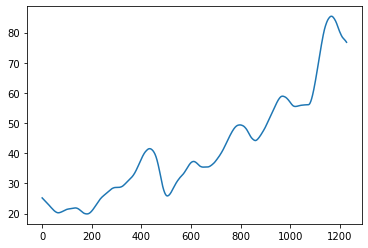

In [214]:
for i in range(1):
    plt.plot(r_km_test_P[:,i])

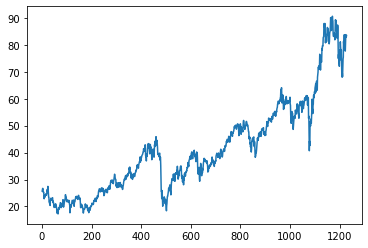

In [215]:
for i in range(1):
    plt.plot(P_sample.iloc[:,i])

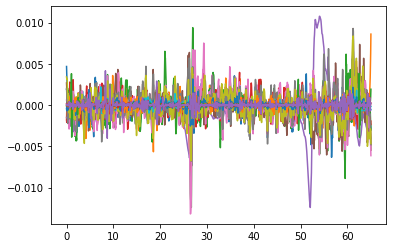

In [118]:
for i in range(15):
    plt.plot(t, r_km[:,i])

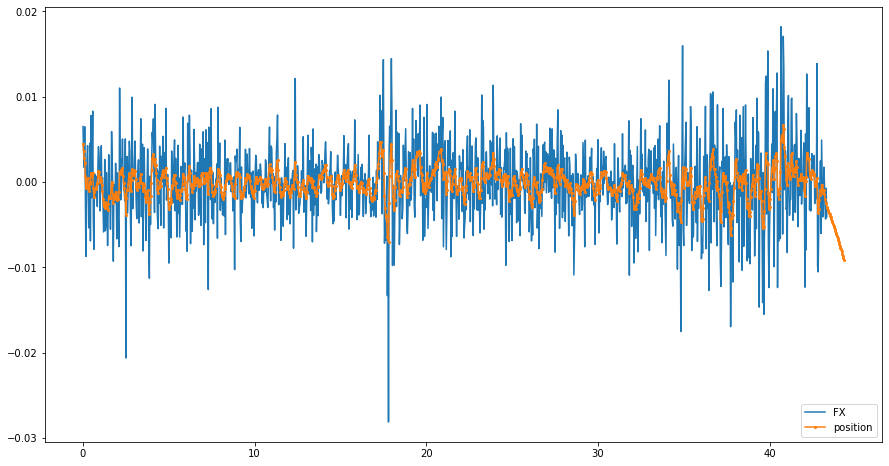

In [161]:
#predicting nexxt 30 steps
fwd_steps = 30
dt = t[1] - t[0]
t_fwd = t.copy()
for i in range(fwd_steps):
    t_fwd = np.append(t_fwd, t_fwd[-1]+dt)

x_point, x_bands = fitKCA(t_fwd, z, q=1e-5, fwd=fwd_steps)[:2]
xr_point, xr_bands = fitKCA(t_fwd, z_r, q=1e-5, fwd=fwd_steps)[:2]

# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
# ax1.plot(t, z, marker='x', linestyle='',label='FX')
# ax1.plot(t_fwd, x_point[:,0], marker='o', linestyle='-', markersize=2, label='position')
# ax1.legend(loc="lower right")

fig, ax2 = plt.subplots(figsize=(15,8))
ax2.plot(t, z_r, linestyle='-',label='FX')
ax2.plot(t_fwd, xr_point[:,0], marker='o', linestyle='-', markersize=2, label='position')
ax2.legend(loc="lower right")
plt.show()

### Paper code replication

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

def getPeriodic(periods, nobs, scale, seed=0):
    t = np.linspace(0, np.pi*periods/2., nobs)
    rnd = np.random.RandomState(seed)
    signal = np.sin(t)
    z = signal + scale * rnd.randn(nobs)
    return t, signal, z

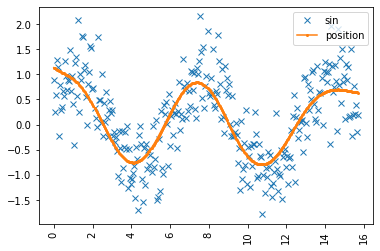

In [131]:
nobs, periods = 300, 10
t, signal, z = getPeriodic(periods, nobs, scale=0.5)
x_point, x_bands = fitKCA(t, z, q=1e-4)[:2]

plt.plot(t, z, marker='x', linestyle='',label='sin')
plt.plot(t, x_point[:,0], marker='o', linestyle='-', markersize=2, label='position')
plt.legend(loc="upper right")
plt.xticks(rotation=90)
plt.show()